# Hebrew Words Analysis

**Submitter:** Eyal Shahimov

## The Goal - Verbs

As the common phrase goes, _"עברית שפה קשה"_.
This is probably true. Hebrew is a complex language with a rich vocabulary and intricate grammar rules.
We will explore some of these challenges by analyzing verbs in Hebrew.
Our goal is to successfully analyze verbs to their roots, pronouns, tenses, etc.

## The Data

Luckily for us, the Hebrew Language Academy provides a free online dictionary.
This dictionary also includes "לוח נטיות פועל" - a conjugation table for verbs.

![image](resources/conjugation_table.png)

This table includes all the information we need to analyze verbs.
It contains the verb's root ("שורש"), tense ("זמן"), pronoun ("גוף") and stem ("בניין").

We will use this data to build a verb analyzer, because the Hebrew Language Academy is the official authority on the Hebrew language.
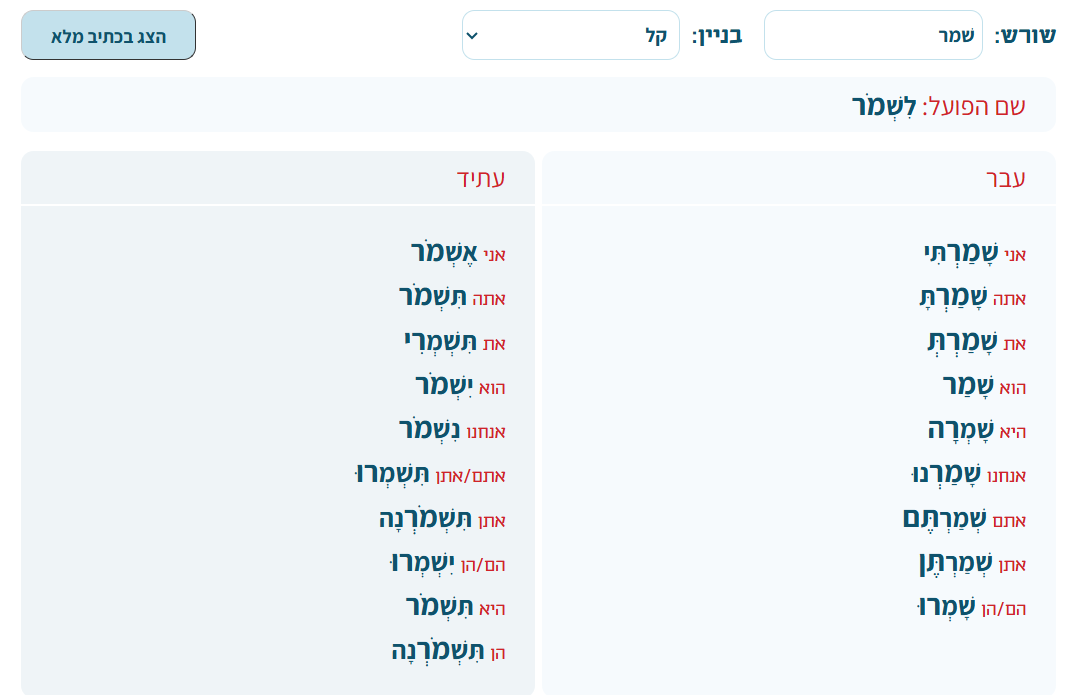

## Data Collection

The is no official API for this dictionary, but we can scrape the data we need.

First, we will inspect the network requests made by the website when we search for a verb.

We notice that after typing at least 2 letters in the search box, the website gives out suggestions for roots.
For example, typing "צה" gives us the following roots: "צהב", "צהל" and "צהר".
This is how it looks in the browser:

![image](resources/prefix_request.png)

Let's take a look at the network requests:
`https://hebrew-academy.org.il/wp-admin/admin-ajax.php?action=get_shoresh_suggestions&_ajax_nonce=b145315ed4&prefix=צה`

The URL contains the path to the ajax request `https://hebrew-academy.org.il/wp-admin/admin-ajax.php`, the specific action we want to perform `action=get_shoresh_suggestions`, a nonce for security `_ajax_nonce=b145315ed4` and the prefix we typed `prefix=צה`.

By sending a GET request to this URL, with all the possible Hebrew prefixes of length 2, we can get all the roots in the dictionary.
Obviously there are no roots of length 1, so it shouldn't be a problem.

What about the conjugation table itself?
When we choose a root and a stem, for example "צהב" and "התפעל" the website gives out the conjugation table.
This is how it looks in the browser:

![image](resources/conjugation_request.png)

Let's take a look at the network requests:
`https://hebrew-academy.org.il/wp-admin/admin-ajax.php?action=get_verb_conjugations&_ajax_nonce=e511734461&shoresh=%D7%A6%D7%94%D7%91&binyan=%D7%94%D7%AA%D7%A4%D7%A2%D7%9C

A similar URL structure, but a different action: `action=get_verb_conjugations`, and different parameters: `shoresh=צהב` and `binyan=התפעל`.
By sending another GET request, this time to the conjugation URL, with all the possible roots and stems, we can get all the conjugation tables in the dictionary.

In [7]:
import pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import product
from tqdm import tqdm
from typing import Tuple, List
import requests
import json

In [8]:
from pydantic import BaseModel

# Data models for the responses
class RootsResponse(BaseModel):
    Shoresh: str
    Binyanim: list[str]
    Info: str

    def as_entries(self):
        return [(self.Shoresh, binyan) for binyan in self.Binyanim]

class ConjugationsResponse(BaseModel):
    KodHatayot: int
    Shoresh: str
    ShoreshWithShinType: str
    Hehara: str
    Mashmaut: str
    class BinyanModel(BaseModel):
        BinyanKod: int
        BinyanName: str
    Binyan: BinyanModel
    class ZmanimModel(BaseModel):
        KodZman: int
        class InnerZmanimModel(BaseModel):
            Zman: str
            class GufimModel(BaseModel):
                GufHebrew: str
                class HatayaMenukkadModel(BaseModel):
                    Text: str
                    HaeimMutham: bool
                HatayaMenukkad: list[list[HatayaMenukkadModel]]
                class HatayaKtivMaleModel(BaseModel):
                    Text: str
                    HaeimMutham: bool
                HatayaKtivMale: list[list[HatayaKtivMaleModel]]

                def get_hataya_menukkad(self):
                    return [''.join(x.Text for x in i) for i in self.HatayaMenukkad]
            Gufim: list[GufimModel]
        Zmanim: list[InnerZmanimModel]
    Zmanim: list[ZmanimModel]

    def get_entries(self):
        entries = []
        root = self.Shoresh.strip()
        stem = self.Binyan.BinyanName.strip()
        for z1 in self.Zmanim:
            for z2 in z1.Zmanim:
                tense = z2.Zman.strip()
                for g in z2.Gufim:
                    for pronoun in g.GufHebrew.split('/'):
                        for conjugation in g.get_hataya_menukkad():
                            entries.append((root, stem, tense, pronoun.strip(), conjugation.strip()))
        return entries

In [9]:
# Website interaction class
class AcademyWebsite:
    def __init__(self, ajax_nonce: str):
        base_url = f'https://hebrew-academy.org.il/wp-admin/admin-ajax.php?_ajax_nonce={ajax_nonce}'
        self.__roots_url = f'{base_url}&action=get_shoresh_suggestions&prefix=%s'
        self.__conjugations_url = f'{base_url}&action=get_verb_conjugations&shoresh=%s&binyan=%s'

        # Standard headers to mimic a real browser
        self.__headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }

        self.__expired_nonce_page = '-1'

    def fetch_roots(self, prefix: str) -> List[RootsResponse] | None:
        while True:
            response, success = self.__request(self.__roots_url % prefix)
            if not success:
                continue
            return [RootsResponse(**entry) for entry in response]


    def fetch_conjugations(self, root: str, stem: str) -> List[ConjugationsResponse] | None:
        while True:
            response, success = self.__request(self.__conjugations_url % (root, stem))
            if not success:
                continue
            return [ConjugationsResponse(**entry) for entry in response]

    def __request(self, url: str):
        page_text = requests.get(url, headers=self.__headers).text
        if page_text == self.__expired_nonce_page:
            raise Exception('Expired nonce')

        response = json.loads(page_text)
        if not response['success']:
            print(response)
            return response, False
        return response['data'], True

In [10]:
# Data registry for roots and stems downloaded from the website
class RootsRegistry:
    def __init__(self, file_path: Path, website: AcademyWebsite):
        self.__file_path = file_path
        self.__website = website
        if not self.__file_path.exists():
            self.__download_roots()
        self.dataframe = self.__load_roots()

    def __load_roots(self) -> pd.DataFrame:
        return pd.read_csv(self.__file_path, encoding='utf-16')

    def __download_roots(self) -> None:
        prefixes = self.__generate_size_2_prefixes()
        results = []
        with ThreadPoolExecutor(max_workers=16) as executor:
            futures = {executor.submit(self.__fetch_and_parse, prefix): prefix for prefix in prefixes}
            for future in tqdm(as_completed(futures), total=len(prefixes)):
                results.extend(future.result())
        df = pd.DataFrame(results, columns=['root', 'stem'])
        df.to_csv(self.__file_path, index=False, encoding='utf-16')

    def __fetch_and_parse(self, prefix: str) -> List[Tuple[str, str]]:
        return [entry for response in self.__website.fetch_roots(prefix) for entry in response.as_entries()]

    @staticmethod
    def __generate_size_2_prefixes() -> List[str]:
        alephbet = 'אבגדהוזחטיכלמנסעפצקרשת'
        finals = 'ךםןףץ'
        alephbet_with_finals = alephbet + finals
        return [''.join(pair) for pair in product(alephbet, alephbet_with_finals)]

In [11]:
# Data registry for conjugations downloaded from the website
class ConjugationsRegistry:
    def __init__(self, file_path: Path, website: AcademyWebsite, roots_df: pd.DataFrame):
        self.__file_path = file_path
        self.__website = website
        self.__roots_df = roots_df
        if not self.__file_path.exists():
            self.__download_conjugations()
        self.dataframe = self.__load_conjugations()

    def __load_conjugations(self) -> pd.DataFrame:
        return pd.read_csv(self.__file_path, encoding='utf-16')

    def __download_conjugations(self) -> None:
        results = []
        with ThreadPoolExecutor(max_workers=16) as executor:
            futures = {executor.submit(self.__fetch_and_parse, e): e for e in self.__roots_df.iterrows()}
            for future in tqdm(as_completed(futures), total=len(futures)):
                df = future.result()
                if not df.empty:
                    results.extend(df.values.tolist())
        df = pd.DataFrame(results, columns=['root', 'stem', 'tense', 'pronoun', 'conjugation']).drop_duplicates()
        df.to_csv(self.__file_path, index=False, encoding='utf-16')

    def __fetch_and_parse(self, e):
        _, (root, stem) = e
        responses = self.__website.fetch_conjugations(root, stem)
        rows = [entry for response in responses for entry in response.get_entries()]
        return pd.DataFrame(rows) if rows else pd.DataFrame()

In [12]:
# Dataset downloading and loading

# Change after nonce expiration
AJAX_NONCE = 'e511734461'
academy_website = AcademyWebsite(AJAX_NONCE)

# Path constants
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)
ROOTS_PATH = Path.joinpath(DATA_DIR, 'roots.csv')
CONJUGATIONS_PATH = Path.joinpath(DATA_DIR, 'conjugations.csv')

roots_registry = RootsRegistry(ROOTS_PATH, academy_website)
print(roots_registry.dataframe.head())

conjugations_registry = ConjugationsRegistry(CONJUGATIONS_PATH, academy_website, roots_registry.dataframe)
print(conjugations_registry.dataframe.head())

   root   stem
0  אסדר   פיעל
1  אסדר  פוּעל
2  אסטר   פיעל
3  אסטר  פוּעל
4  אסכם   פיעל
   root   stem tense pronoun    conjugation
0  אסדר  פוּעל   עבר     אני  אֻסְדַּרְתִּי
1  אסדר  פוּעל   עבר     אתה   אֻסְדַּרְתָּ
2  אסדר  פוּעל   עבר      את   אֻסְדַּרְתְּ
3  אסדר  פוּעל   עבר     הוא       אֻסְדַּר
4  אסדר  פוּעל   עבר     היא     אֻסְדְּרָה
